# Working with discourse-level annotations

In the previous sections, we have created linguistic annotations for plain text using various natural language processing techniques.

In this section, we learn how to use pre-existing linguistic annotations, focusing especially on annotations that target phenomena above the level of a clause.

After reading through this section, you should:

 - know the basics of the CoNLL-U annotation schema
 - know how to create a spaCy *Doc* object manually
 - know how to annotate *Spans* in a *Doc* object using *SpanGroups*
 - know how to load CoNLL-U annotated corpora into spaCy

## Introducing the CoNLL-U annotation schema

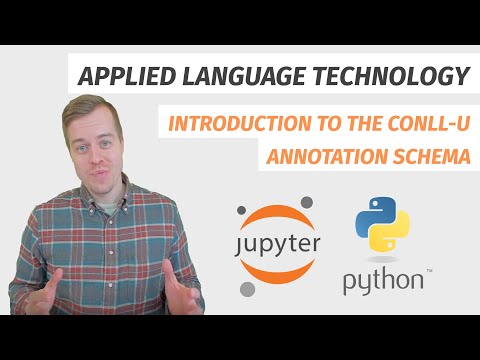

In [1]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('YU7MtTDu1g8', height=350, width=600)

CoNLL-X is an annotation schema for describing linguistic features across diverse languages (Buchholz and Marsi [2006](https://www.aclweb.org/anthology/W06-2920)), which was originally developed to facilitate collaboration on so-called shared tasks in research on natural language processing (see e.g. Nissim et al. [2017](https://doi.org/10.1162/COLI_a_00304)).

[CoNLL-U](https://universaldependencies.org/format.html) is a further development of this annotation schema for the Universal Dependencies formalism, which was introduced in [Part III](02_universal_dependencies.ipynb). This annotation schema is commonly used for distributing linguistic corpora in projects that build on this formalism, but it is not uncommon to see other projects use CoNLL-U as well.

In addition to [numerous modern languages](https://universaldependencies.org/), one can find, for example, CoNLL-U annotated corpora for ancient languages such Akkadian (Luukko et al. [2020](https://www.aclweb.org/anthology/2020.tlt-1.11)) and Coptic (Zeldes and Abrams [2018](https://www.aclweb.org/anthology/W18-6022)).

### The components of the CoNLL-U annotation schema

CoNLL-U annotations are distributed as plain text files (see [Part II](http://localhost:8888/notebooks/part_ii/01_basic_text_processing.ipynb#Computers-and-text)).

The annotation files contain three types of lines: **comment lines**, **word lines** and **blank lines**.

**Comment lines** precede word lines and start with a hash character (#). These lines can be used to provide metadata about the word lines that follow.

Each **word line** contains annotations for a single word or token. Larger linguistic units are represented by subsequent word lines.

The annotations for a word line are provided using the following fields, each separated by a tabulator character:

```console
ID	FORM	LEMMA	UPOS	XPOS	FEATS	HEAD	DEPREL	DEPS	MISC
```

 1. `ID`: Index of the word in sequence
 2. `FORM`: The form of a word or punctuation symbol
 3. `LEMMA`: Lemma or the base form of a word
 4. `UPOS`: [Universal part-of-speech tag](https://universaldependencies.org/u/pos/)
 5. `XPOS`: Language-specific part-of-speech tag
 6. `FEATS`: [Morphological features](https://universaldependencies.org/u/feat/index.html)
 7. `HEAD`: Syntactic head of the current word
 8. `DEPREL`: Universal dependency relation to the `HEAD`
 9. `DEPS`: [Enhanced dependency relations](https://universaldependencies.org/u/overview/enhanced-syntax.html)
 10. `MISC`: Any additional annotations
 
Finally, a **blank line** after word lines is used to separate sentences.

### Interacting with CoNLL-U annotations in Python

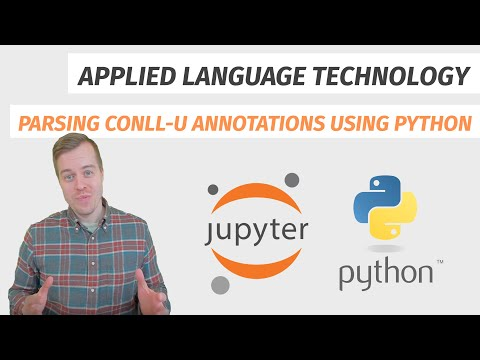

In [2]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('lvJRFMvWtFI', height=350, width=600)

To explore CoNLL-U annotations using Python, let's start by importing [conllu](https://github.com/EmilStenstrom/conllu/), a small library for parsing CoNLL-U annotations into various data structures native to Python.

In [3]:
# Import the conllu library
import conllu

We then open a plain text file with annotations in the CoNLL-U format from the [Georgetown University Multilayer Corpus](https://corpling.uis.georgetown.edu/gum/) (GUM; see Zeldes [2017](http://dx.doi.org/10.1007/s10579-016-9343-x)), read its contents using the `read()` method and store the result under the variable `annotations`.

In [4]:
# Open the plain text file for reading; assign under 'data'
data = open("data/GUM_whow_parachute.conllu", mode="r", encoding="utf-8")

# Read the file contents and assign under 'annotations'
annotations = data.read()

# Check the type of the resulting object
type(annotations)

str

This gives us a Python string object. Let's print out the first 1000 characters of this string.

In [5]:
# Print the first 1000 characters of the string under 'annotations'
print(annotations[:1000])

# newdoc id = GUM_whow_parachute
# sent_id = GUM_whow_parachute-1
# text = How to Cope With a Double Parachute Failure
# s_type = inf
1	How	how	SCONJ	WRB	PronType=Int	3	mark	_	Discourse=preparation:1->11
2	to	to	PART	TO	_	3	mark	_	_
3	Cope	Cope	VERB	VB	VerbForm=Inf	0	root	_	_
4	With	with	ADP	IN	_	8	case	_	_
5	a	a	DET	DT	Definite=Ind|PronType=Art	8	det	_	Entity=(event-1
6	Double	double	ADJ	JJ	Degree=Pos	8	amod	_	_
7	Parachute	parachute	NOUN	NN	Number=Sing	8	compound	_	Entity=(object-2)
8	Failure	failure	NOUN	NN	Number=Sing	3	obl	_	Entity=event-1)

# sent_id = GUM_whow_parachute-2
# text = While skydiving, it is possible (yet extremely unlikely) that both your primary and reserve parachutes will malfunction, leaving you with no method of reducing your velocity.
# s_type = decl
1	While	while	SCONJ	IN	_	2	mark	_	Discourse=circumstance:2->3
2	skydiving	skydiving	NOUN	NN	Number=Sing	6	advcl	_	Entity=(event-3)|SpaceAfter=No
3	,	,	PUNCT	,	_	2	punct	_	_
4	it	it	PRON	PRP	Case=Nom|Gender=Neut|Num

As you can see, the string object contains comment lines (prefixed with a hash), followed by word lines that contain the annotations for the fields introduced above. 

An underscore `_` is used to indicate fields with empty or missing values on the word lines. 

In the GUM corpus, the final field `MISC` contains values such as `Discourse` and `Entity` that provide annotations for discourse relations and entities such as events and objects.

Here the question is: how to extract all this information programmatically from a Python *string* object, which we cannot access like a list or a dictionary?

This is where the `conllu` module steps in, because its `parse()` function is capable of extracting information from CoNLL-U formatted strings.

In [6]:
# Use the parse() function to parse the annotations; store under 'sentences'
sentences = conllu.parse(annotations)

The `parse()` function returns a Python list populated by *TokenList* objects. This object type is native to the conllu library.

Let's examine the first item in the list `sentences`.

In [7]:
sentences[0]

TokenList<How, to, Cope, With, a, Double, Parachute, Failure>

This gives us a *TokenList* object.

To start with, the information contained in the hash-prefixed comment lines in the CoNLL-U schema is provided under the `metadata` attribute.

In [8]:
# Get the metadata for the first item in the list
sentences[0].metadata

{'newdoc id': 'GUM_whow_parachute',
 'sent_id': 'GUM_whow_parachute-1',
 'text': 'How to Cope With a Double Parachute Failure',
 's_type': 'inf'}

This shows how the GUM corpus uses the comment lines to provide four types of metadata for each sentence: `newdoc_id` for document identifier, `sent_id` for sentence identifier, `text` for plain text and `s_type` for the grammatical mood of the sentence (Zeldes & Simonson [2017](https://www.aclweb.org/anthology/W16-1709): 69).

Superficially, the object stored under the `metadata` attribute looks like a Python dictionary, but the object is actually a conllu *Metadata* object.

This object, however, behaves just like a Python dictionary in the sense that it consists of key and value pairs, which are accessed just like those in a dictionary.

To exemplify, to retrieve the sentence type (or its grammatical mood), simply use the key `s_type` to access the *Metadata* object.

In [9]:
# Get the sentence type under 's_type'
sentences[0].metadata['s_type']

'inf'

This returns the string `inf`, which corresponds to infinitive.

Coming back to the *TokenList* object, as the name suggest, the items in a *TokenList* consist of individual *Token* objects.

Let's access the first *Token* object `[0]` in the first *TokenList* object `[0]` under `sentences`. 

In [10]:
# Get the first token in the first sentence
sentences[0][0]

{'id': 1,
 'form': 'How',
 'lemma': 'how',
 'upos': 'SCONJ',
 'xpos': 'WRB',
 'feats': {'PronType': 'Int'},
 'head': 3,
 'deprel': 'mark',
 'deps': None,
 'misc': {'Discourse': 'preparation:1->11'}}

Just like the *TokenList* above, the *Token* is a dictionary-like object with keys and values.

The dictionary under the key `misc` holds information about discourse relations, which describe how parts of a text relate to each other using a formalism named [Rhetorical Structure Theory](https://www.sfu.ca/rst) (Mann & Thompson [1988](https://doi.org/10.1515/text.1.1988.8.3.243)).

In this case, the annotation states that a discourse relation named **preparation** holds between units 1 and 11.

These units and their identifiers do not correspond words or sentences in the document, but to *elementary discourse units*. 

These elementary discourse units define an additional level of *segmentation*, which seeks to define units of discourse that are placed in various relations to one another.

In classical Rhetorical Structure Theory, these elementary discourse units (abbreviated EDU) often correspond to clauses, but this is not a requirement set by the theory.

## Adding discourse-level annotations to *Doc* objects

As pointed out above, the GUM corpus uses the key `Discourse` in the `misc` field to indicate the **beginning** of an elementary discourse unit.

By tracking *Token* objects with these properties, we can identify the boundaries of elementary discourse units, which are not necessarily aligned with sentences in the *TokenList* object.

We can keep track of these boundaries by counting *Tokens* and noting down the indices of *Tokens* that contain the `Discourse` key under `misc`.

Let's set up a variable for counting the *Tokens* and several lists for holding the information that we will collect from the *TokenList* objects.

In [11]:
# Set up a variable with value 0 that we will use for counting
# the Tokens that we process
counter = 0

# We use these lists to keep track of sentences, discourse units
# and the relations that hold between them.
discourse_units = []
sent_types = []
relations = []

# Set up placeholder lists for the information that we will extract
# from the CoNLL-U annotations. These lists will be used to create 
# a spaCy Doc object below.
words = []
spaces = []
sent_starts = []

We use the value stored under the variable `counter` to keep track of the boundaries for elementary discourse units as we loop over the *TokenList* objects stored in the list `sentences`.

In [12]:
# Loop over each TokenList object
for sentence in sentences:
    
    # When we begin looping over a new sentence, set the value of
    # the variable 'is_start' to True. This marks the beginning of
    # a sentence.
    is_start = True
    
    # Add the current sentence type to the list 'sent_types'
    sent_types.append(sentence.metadata['s_type'])
        
    # Proceed to loop over the Tokens in the current TokenList object
    for token in sentence:
        
        # Use the key 'form' to retrieve the word form for the 
        # Token and append it to the placeholder list 'words'.
        words.append(token['form'])
        
        # Check if this Token begins a sentence by evaluating whether
        # the variable 'is_start' is True. 
        if is_start:
            
            # If the Token starts a sentence, add value True to the list
            # 'sent_starts'. Note the missing quotation marks: this is a 
            # Boolean value (True / False).
            sent_starts.append(True)
            
            # Set the variable 'is_start' to False until the next sentence
            # starts and the variable is set to True again.
            is_start = False
        
        # If the variable 'is_start' is False, execute the code block below
        else:
            
            # Append value 'False' to the list 'sent_starts'
            sent_starts.append(False)
        
        # Check if the key 'misc' contains anything, and if the key
        # holds the value 'Discourse', proceed to the code block below.
        if token['misc'] is not None and 'Discourse' in token['misc']:
            
            # The presence of the key 'Discourse' indicates the beginning
            # of a new elementary discourse unit; add its index to the list
            # 'discourse_units'.
            discourse_units.append(counter)
            
            # Unpack the relationship definition; start by splitting the
            # relation name from the elementary discourse units. Assign
            # the resulting objects under 'relation' and 'edus'.
            relation, edus = token['misc']['Discourse'].split(':')
            
            # Try to split the relation annotation into two parts
            try:
                
                # Split at the '->' string and assign to 'source'
                # and 'target', respectively.
                source, target = edus.split('->')
                
                # Deduct -1 from both 'source' and 'target', because 
                # the identifiers used in the GUM corpus are not 
                # zero-indexed, but our spaCy Spans that correspond to
                # elementary discourse units will be. Also cast the
                # numbers into integers (these are originally strings!).
                source, target = int(source) - 1, int(target) - 1
            
            # The root node of the RST tree will not have a target,
            # which raises a ValueError since there is only one item.
            except ValueError:
                
                # Assign the first item in 'edus' to 'source' and set
                # target to None. 
                source, target = edus[0], None
                
                # Deduct -1 from 'source' as explained above.
                source = int(source) - 1 
                
            # Compile the relation definition into a three tuple and
            # append to the list 'relations'.
            relations.append((relation, source, target))
            
        # Check if the current Token is followed by a whitespace. If this is
        # not the case, e.g. for the Token at the end of a TokenList, this
        # information is available under the 'misc' key.
        if token['misc'] is not None and 'SpaceAfter' in token['misc']:
            
            # If the 'misc' key holds a dictionary with the key 'SpaceAfter'
            # with a value 'No', proceed below
            if token['misc']['SpaceAfter'] == 'No':
                
                # Append the Boolean value 'False' to the list 'spaces'.
                spaces.append(False)
            
        # If the 'SpaceAfter' key is not found under 'misc', the token is followed
        # by a space.
        else:

            # Append True to the list of spaces
            spaces.append(True)
        
        # Update the counter as we finish looping over a Token object
        # by adding +1 to its value.
        counter += 1

This collects the information needed for creating a spaCy *Doc* object, together with the discourse-level annotations that we will add to the *Doc* object afterwards.

As the example above shows, collecting this kind of information from annotations requires one to be familiar with the annotation schema, particularly in terms of how additional information stored under the field `misc` for *Tokens* or in the metadata for *TokenLists*, in order to catch any potential errors.

Moving ahead, we typically create spaCy *Doc* objects by passing some text to a *Language* object, as shown in [Part II](../part_ii/03_basic_nlp.ipynb), which takes care of operations such as tokenization.

In this case, however, we need to preserve the tokens defined in the CoNLL-U annotations, because this information is needed to align the discourse-level annotations correctly for both sentences and elementary discourse units.

In other words, we cannot take the risk that spaCy tokenises the text differently, because this would result in misaligned annotations for sentences and elementary discourse units.

Thus we create a spaCy *Doc* object manually by importing the *Doc* class from spaCy's `tokens` submodule. We also load a small language model for English and store it under the variable `nlp`.

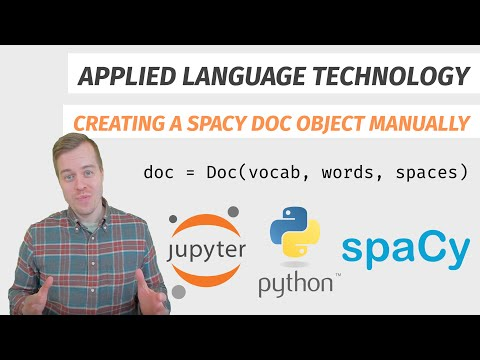

In [13]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('zYXYK4KbgeI', height=350, width=600)

In [14]:
# Import the Doc class and the spaCy library
from spacy.tokens import Doc
import spacy

# Load a small language model for English; store under 'nlp'
nlp = spacy.load('en_core_web_sm')

We can now use the *Doc* class to create *Doc* objects manually by providing the information collected in the lists `words`, `spaces` and `sent_starts` as input to the newly-created *Doc* object.

Let's take a quick look at the information we collected into the lists.

In [15]:
# Loop over the first 15 items in lists 'words', 'spaces' and 'sent_starts'.
# Use the zip() function to fetch items from these lists simultaneously.
for word, space, sent_start in zip(words[:15], spaces[:15], sent_starts[:15]):
    
    # Print out the current item in each list
    print(word, space, sent_start)

How True True
to True False
Cope True False
With True False
a True False
Double True False
Parachute True False
Failure True False
While True True
skydiving False False
, True False
it True False
is True False
possible True False
( False False


In addition, we must pass a *Vocabulary* object to the `vocab` argument to associate the *Doc* with a given language, as normally this information is assigned by the *Language* object.

In [16]:
# Create a spaCy Doc object "manually"; assign under the variable 'doc'
doc = Doc(vocab=nlp.vocab, 
          words=words, 
          spaces=spaces,
          sent_starts=sent_starts
          )

This gives us a *Doc* object with pre-defined *Tokens* and sentence boundaries.

In [17]:
# Retrieve Tokens up to index 15 from the Doc object
doc[:15]

How to Cope With a Double Parachute Failure While skydiving, it is possible (

As you can see, spaCy has successfully assigned the words in `words` to *Token* objects, while the Boolean values in `spaces` determine whether a *Token* is followed by a space or not.

The sentence boundaries in `sent_starts`, in turn, are used to define the sentences under the attribute `sents` of a *Doc* object.

In [18]:
# Retrieve the first five sentences in the Doc object
list(doc.sents)[:5]

[How to Cope With a Double Parachute Failure,
 While skydiving, it is possible (yet extremely unlikely) that both your primary and reserve parachutes will malfunction, leaving you with no method of reducing your velocity.,
 In the vast majority of cases, this will not occur;,
 nevertheless, in this event these coping strategies may assist.,
 Steps]

However, because we discarded the linguistic information contained in the CoNLL-U annotations, the attributes of the *Token* objects in our *Doc* object are empty.

Let's fetch the fine-grained part-of-speech tag for the first *Token* in the *Doc* object.

In [19]:
# Get the fine-grained part-of-speech tag for Token at index 0
doc[0].tag_

''

As this shows, the `tag_` attribute of the *Token* does not exist.

We cannot pass our *Doc* object `doc` directly to the language model under `nlp` for additional annotations, but we need to create these manually by providing the *Doc* separately to various components of the natural language processing pipeline in the *Language* object.

These components are accessible under the attribute `pipeline`, as we learned in [Part II](../part_ii/04_basic_nlp_continued.ipynb).

Let's loop over the components of the `pipeline` and apply them to the *Doc* object under `doc`.

In [20]:
# Loop over the name / component pairs under the 'pipeline' attribute
# of the Language object 'nlp'.
for name, component in nlp.pipeline:
    
    # Use a formatted string to print out the 'name' of the component
    print(f"Now applying component {name} ...")
    
    # Feed the existing Doc object to the component and store the updated
    # annotations under the variable of the same name ('doc').
    doc = component(doc)

Now applying component tok2vec ...
Now applying component tagger ...
Now applying component parser ...
Now applying component attribute_ruler ...
Now applying component lemmatizer ...
Now applying component ner ...


If we now examine the attribute `tag_` of the first *Token* object, the fine-grained part-of-speech tag has been added to the *Token*.

In [21]:
# Get the fine-grained part-of-speech tag for Token at index 0
doc[0].tag_

'WRB'

Furthermore, we now have access to additional linguistic annotations produced by spaCy, such as noun phrases under the attribute `noun_chunk`.

In [22]:
# Get the first five noun phrases in the Doc object
list(doc.noun_chunks)[:5]

[a Double Parachute Failure,
 it,
 both your primary and reserve parachutes,
 you,
 no method]

Our manually-defined sentence boundaries, however, remain the same, although normally spaCy uses the syntactic dependencies to segment text into sentences!

In [23]:
# Get the first five sentences in the Doc object
list(doc.sents)[:5]

[How to Cope With a Double Parachute Failure,
 While skydiving, it is possible (yet extremely unlikely) that both your primary and reserve parachutes will malfunction, leaving you with no method of reducing your velocity.,
 In the vast majority of cases, this will not occur;,
 nevertheless, in this event these coping strategies may assist.,
 Steps]

Now that we have a fully-annotated *Doc* object, we can proceed to enhance this object with discourse-level annotations collected from the CoNLL-U annotations, which are stored in the lists `discourse_units`, `sent_types` and `relations`.

### Adding information on sentence mood

Let's start by adding information on sentence type to the *Doc* object, which we collected into the list `sent_types`.

These annotations provide information on grammatical mood of the sentence, as exemplified by categories such as *infinitive*, *declarative* and *imperative*.

Let's check out the first ten items in the list `sent_types`.

In [24]:
# Print out the 
sent_types[:10]

['inf', 'decl', 'decl', 'decl', 'frag', 'imp', 'decl', 'imp', 'imp', 'imp']

These are the categories that we want to associate with each sentence in the *Doc* object.

Before proceeding, let's make sure that the lengths for the `sent_types` list and the sentences in the *Doc* object match each other.

In [25]:
# Check the length of sentence type information and 
# the number of sentences in the Doc object.
len(sent_types) == len(list(doc.sents))

True

In spaCy, information on grammatical mood of a sentence is best represented using a custom attribute for a *Span* object, as these objects consist of sequences of *Token* objects within a *Doc*.

Actually, the sentences available under the attribute `sents` of a *Doc* object, whose mood we want to describe, are *Span* objects.

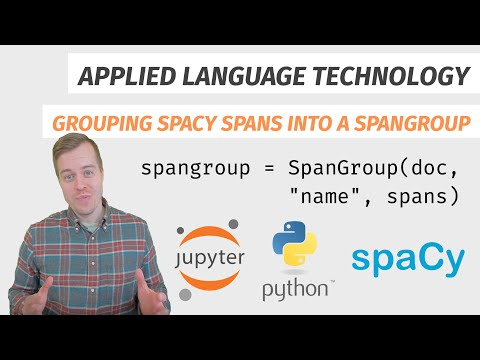

In [26]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('9S0MT4xISW0', height=350, width=600)

In [27]:
# Print out the first sentence in the Doc and its type()
list(doc.sents)[0], type(list(doc.sents)[0])

(How to Cope With a Double Parachute Failure, spacy.tokens.span.Span)

To assign information on grammatical mood to these *Spans*, let's continue by importing two classes: *SpanGroup* and *Span*.

In [28]:
# Import the SpanGroup and Span classes from spaCy
from spacy.tokens.span_group import SpanGroup
from spacy.tokens import Span

As instructed in [Part II](../part_ii/04_basic_nlp_continued.ipynb), the *Span* class is needed to register a custom attribute for storing information on grammatical mood for *Span* objects.

The *SpanGroup*, in turn, is a class that allows defining groups of *Span* objects, which can be stored under the `spans` attribute of a *Doc* object.

Let's create a *SpanGroup* object that contains *Spans* that correspond to the sentences under the `sents` attribute in the *Doc* object.

This requires three arguments: `doc`, which takes the *Doc* object that contains the *Spans* to be grouped, a `name` for the *SpanGroup* and `spans`, a list of *Span* objects in the *Doc* object referred to in `doc`.

In [29]:
# Create a SpanGroup from Spans contained in the Doc object 'doc', which
# was created from the CoNLL-U annotations. These Spans correspond to
# sentences, whose boundaries we defined manually. Assign to variable
# 'sent_group'.
sent_group = SpanGroup(doc=doc, name="sentences", spans=list(doc.sents))

This creates a *SpanGroup* object, which we can then assign to the `spans` attribute of the *Doc* object.

In [30]:
# Assign the SpanGroup to the 'spans' attribute of the Doc object under the
# key 'sentences'.
doc.spans['sentences'] = sent_group

Next, we register the custom attribute `mood` with the *Span* class, and assign it with the default value `None`.

In [31]:
# Register the custom attribute 'mood' with the Span class
Span.set_extension('mood', default=None)

We then use Python's `zip()` function to iterate over pairs of items in the list `sent_types` and the *SpanGroup* object stored under the key `sentences` in the `spans` attribute of the *Doc* object.

During each loop, we refer to the sentence type information from the `sent_types` list as `mood` and to the *Span* object as `span`.

We then assign the value stored under the variable `mood` to the custom attribute `mood` of the *Span* object under `span`.

Remember that spaCy uses an underscore `_` as a dummy attribute for user-defined attributes, as explained in [Part II](../part_ii/04_basic_nlp_continued.ipynb). 

In [32]:
# Loop over pairs of items from the list and the SpanGroup
for mood, span in zip(sent_types, doc.spans['sentences']):
    
    # Assign the value of 'mood' under the custom attribute
    # with the same name, which belongs to the Span object.
    span._.mood = mood

This adds information on grammatical mood under the custom attribute `mood` of each *Span* object.

Let's retrieve the sentence stored under index 8 and information on its mood.

In [33]:
# Retrieve information on grammatical mood for sentence at index 8
doc.spans['sentences'][8], doc.spans['sentences'][8]._.mood

(If both your primary and reserve chutes have malfunctioned, signal immediately to a fellow jumper who has not yet deployed their chute, waving your arms and signalling that your own is not functional.,
 'imp')

As you can see, this returns a sentence with imperative mood, which suggests that this information has been successfully added to the *Doc* object.

### Adding information on discourse relations

For defining the boundaries of elementary discourse units, we need to use the information contained in the list `discourse_units`.

In [34]:
# Check the first 10 items in the list 'discourse_units'
discourse_units[:10]

[0, 8, 11, 14, 19, 29, 34, 39, 51, 62]

We created this list above by noting down the index of each *Token* that marked the beginning of an elementary discourse unit.

What we need to do next is to use these indices to get slices of the *Doc* object, that is, *Span* objects that correspond to the discourse units.

We can do this by looping over the numbers stored in the `discourse_units` list and use them for determining the beginning and end of a *Span* as shown below.

In [35]:
# Create a placeholder list to hold slices of the Doc object that correspond
# to discourse units.
edu_spans = []

# Proceed to loop over discourse unit boundaries using Python's range() function.
# This will give us numbers, which we use to index the 'discourse_units' list that
# contains the indices that mark the beginning of a discourse unit.
for i in range(len(discourse_units)):
    
    # Try to execute the following code block
    try:
        
        # Get the current item in the list 'discourse_units' and the next item; assign
        # under variables 'start' and 'end'.
        start, end = discourse_units[i], discourse_units[i + 1]
    
    # If the next item is not available, because we've reached the final item in the list,
    # this will raise an IndexError, which we catch here.
    except IndexError:
        
        # Assign the start of the discourse unit as usual, set the length of the Doc 
        # object as the value for 'end' to mark the end point of the discourse unit. 
        start, end = discourse_units[i], len(doc)

    # Use the 'start' and 'end' variables to slice the Doc object; append the
    # resulting Span object to the list 'edu_spans'.
    edu_spans.append(doc[start:end])

This gives us a list of *Span* objects that correspond to the elementary discourse units. 

In [36]:
# Get the first seven Spans in the list 'edu_spans'
edu_spans[:7]

[How to Cope With a Double Parachute Failure,
 While skydiving,,
 it is possible,
 (yet extremely unlikely),
 that both your primary and reserve parachutes will malfunction,,
 leaving you with no method,
 of reducing your velocity.]

As you can see, the elementary discourse units are not necessary aligned with sentences.

Next, we must register additional custom attributes for the *Span* object that will hold the annotations for discourse relations.

In [37]:
# Register three custom attributes for Span objects, which correspond to
# elementary discourse unit id, the id of the element acting as the target,
# and the name of the relation.
Span.set_extension('edu_id', default=None)
Span.set_extension('target_id', default=None)
Span.set_extension('relation', default=None)

The attribute `edu_id` will hold the unique identifier for each elementary discourse unit, whereas the `target_id` attribute contains the identifier of the discourse unit that the current discourse unit is related to.

The `relation` attribute, in turn, contains the name of the discourse relation that holds between the participating units.

Just as above, we use the *SpanGroup* object to store these *Spans* under the key `edus` of the `spans` attribute.

In [38]:
# Create a SpanGroup object from the Spans in the 'edu_spans' list
edu_group = SpanGroup(doc=doc, name="edus", spans=edu_spans)

# Assign the SpanGroup under the key 'edus'
doc.spans['edus'] = edu_group

Next, we populate the custom attributes of these *Span* objects with information stored in the list `relations`.

When extracting information from the CoNLL-U annotations, we collected information on discourse relations into three-tuples in which the first item gives the relation, whereas the remaining two items give the identifiers for elementary discourse units participating in the relation. The first identifier determines the "source" of the relation whereas the second is the "target". 

In [39]:
# Print out the first five relation definitions in the list 'relations'
relations[:5]

[('preparation', 0, 10),
 ('circumstance', 1, 2),
 ('background', 2, 8),
 ('concession', 3, 2),
 ('same-unit', 4, 2)]

We now proceed to loop over the list `relations` and assign this information into the *Spans* in the *SpanGroup* under the key `edus` of the `spans` attribute.

In [40]:
# Loop over each three-tuple in the list 'relations'
for relation in relations:
    
    # Split the three-tuple into three variables
    rel_name, source, target = relation[0], relation[1], relation[2]
    
    # Use the identifier under 'source' to index the Span objects under
    # the key 'edus'. Then access the custom attributes and set the values
    # for 'edu_id', 'target_id' and 'relation'.
    doc.spans['edus'][source]._.edu_id = source
    doc.spans['edus'][source]._.target_id = target
    doc.spans['edus'][source]._.relation = rel_name

This stores the information on the discourse relations under the custom attributes.

We can examine the result by retrieving the custom attribute `relation` for the *Span* under index 1 in the *Doc* object `doc`.

In [41]:
# Retrieve the custom attribute 'relation' for the Span at index 1
doc.spans['edus'][1]._.relation

'circumstance'

This indicates that this *Span* participates in a circumstantial relation with another unit, whose identifier is stored under the custom attribute `target_id`.

Because the attribute `target_id` contains an integer that identifies another discourse unit, we can use this value to index the *SpanGroup* object under `doc.spans['edus']` to retrieve the target.

In [42]:
# Get the Span at index 1 and the Span referred to by its 'target_id' attribute
doc.spans['edus'][1], doc.spans['edus'][doc.spans['edus'][1]._.target_id]

(While skydiving,, it is possible)

This gives us the two elementary discourse units participating in the "circumstance" relation.

## Converting CoNLL-U annotations into *Doc* objects

If you do not need to enrich spaCy objects with additional information, but simply wish to convert CoNLL-U annotations into *Doc* objects, spaCy provides a convenience function, `conllu_to_docs()`, for converting CoNLL-U annotated data into spacy *Doc* objects.

Let's start by importing the function from the `training` submodule, as this function is mainly used for loading CoNLL-U annotated data for training language models. We also import the class for the *Doc* object.

In [43]:
# Import the 'conllu_to_docs' function and the Doc class
from spacy.training.converters import conllu_to_docs
from spacy.tokens import Doc

The `conllu_to_docs()` function takes a Python string object as input.

We pass the string object `annotations` that contains CoNLL-U annotations to the function, and set the argument `no_print` to `True` to prevent the `conllu_to_docs()` function from printing status messages.

The function returns a Python generator object, which we must cast into a list to examine its contents.

In [44]:
# Provide the string object under 'annotations' to the 'conllu_to_docs' function. 
# Set 'no_print' to True and cast the result into a Python list; store under 'docs'.
docs = list(conllu_to_docs(annotations, no_print=True))

# Get the first two items in the resulting list
docs[:2]

[How to Cope With a Double Parachute Failure While skydiving, it is possible (yet extremely unlikely) that both your primary and reserve parachutes will malfunction, leaving you with no method of reducing your velocity. In the vast majority of cases, this will not occur; nevertheless, in this event these coping strategies may assist. Steps Remain calm. This may seem obvious, but deep, even breathing (despite the rushing slipstream) and controlling your heart-rate are essential to your continued survival. Entreat assistance. If both your primary and reserve chutes have malfunctioned, signal immediately to a fellow jumper who has not yet deployed their chute, waving your arms and signalling that your own is not functional. If this is a solo jump, then skip to step 6. ,
 Prepare for deployment. After linking arms with your fellow jumper, you will need to hook your arms through their chest strap, or through both sides of the front of their harness, as far as you can, then grab onto your ow

This gives us a list with *Doc* objects. By default, the `conllu_to_docs()` function groups every ten sentences in the CoNLL-u files into a single spaCy object. 

This, however, is not an optimal solution, as having every document its own *Doc* object would make more sense rather than an arbitrary grouping.

To do so, we can use the `from_docs()` method of the *Doc* object to combine the *Doc* objects in the list `docs`. 

In [45]:
# Combine Doc objects in the list 'docs' into a single Doc; assign under 'doc'
doc = Doc.from_docs(docs)

# Check variable type and length
type(doc), len(doc)

(spacy.tokens.doc.Doc, 890)

This gives us a single spaCy *Doc* object with 890 *Tokens*.

If we loop over the first eight *Tokens* in the *Doc* object `doc` and print out their linguistic annotations, the results shows that the information from the CoNLL-U annotations have been carried over to the *Doc* object.

In [46]:
# Loop over the first 8 Tokens using the range() function
for token_ix in range(0, 8):
    
    # Use the current number under 'token_ix' to fetch a Token from the Doc.
    # Assign the Token object under the variable 'token'. 
    token = doc[token_ix]
    
    # Print the Token and its linguistic annotations
    print(token, token.tag_, token.pos_, token.morph, token.dep_, token.head)

How WRB SCONJ PronType=Int mark Cope
to TO PART  mark Cope
Cope VB VERB VerbForm=Inf ROOT Cope
With IN ADP  case Failure
a DT DET Definite=Ind|PronType=Art det Failure
Double JJ ADJ Degree=Pos amod Failure
Parachute NN NOUN Number=Sing compound Failure
Failure NN NOUN Number=Sing obl Cope


However, if we attempt to retrieve the noun phrases in the *Doc* objects available under the attribute `noun_chunks`, spaCy will return an error.

In [47]:
# Get the noun chunks in the Doc
list(doc.noun_chunks)

NotImplementedError: [E894] The 'noun_chunks' syntax iterator is not implemented for language ''.

This raises an error, because the *Doc* that we created using the `conllu_to_docs()` function does not have a *Language* and a *Vocabulary* associated with it.

The noun phrases are created using language-specific rules from syntactic parses, but spaCy does not know which language it is working with.

Because the language of a *Doc* cannot be defined manually, we must use a trick involving the *DocBin* object that we learned about in [Part II](../part_ii/04_basic_nlp_continued.ipynb#Writing-processed-texts-to-disk).

The *DocBin* is a special object type for writing spaCy annotations to disk.

In [48]:
# Import the DocBin object from the 'tokens' submodule
from spacy.tokens import DocBin

# Create an empty DocBin object
doc_bin = DocBin()

# Add the current Doc to the DocBin
doc_bin.add(doc)

Instead of writing the *DocBin* object to disk, we simply retrieve the *Doc* objects from the *DocBin* using the `get_docs()` method, which requires a *Vocabulary* object as input to the `vocab` argument.

The *Vocabulary* is used to associate the *Doc* objects with a given language.

The `get_docs()` method returns a generator, which we must cast into a list.

In [49]:
# Use the 'get_docs' method to retrieve the Docs from the DocBin
docs = list(doc_bin.get_docs(vocab=nlp.vocab))

If we now examine the *Doc* object, which is naturally the first and only item in the list, and retrieve its attribute `noun_chunks`, we can also get the noun phrases.

In [50]:
list(docs[0].noun_chunks)[:10]

[it,
 and reserve parachutes,
 this,
 these coping strategies,
 Steps,
 This,
 both your primary and reserve chutes,
 who,
 this,
 you]

This section should have given you a basic understanding of the CoNLL-U annotation schema and how corpora annotated using this schema can be added to spaCy objects.